## データファイルの読み込み
- 遺伝子発現量・比較結果のファイル
- 遺伝子の詳細情報リスト（BLAST結果）
- 遺伝子のGO_IDリスト

In [141]:
# ファイル名
RES_FILE = 'DE_result2.txt'  # 遺伝子発現量・比較結果
BST_FILE = 'DEGs_BLAST.txt' # 詳細情報リスト（BLAST結果）
GO_FILE  = 'DEGs_GO.txt'    # GO_IDリスト

In [142]:
# パッケージやツールをインポート
import pandas as pd
%matplotlib inline

# 読み込み
RES = pd.read_csv(RES_FILE, sep='\t', header=0,  index_col=0)
BST = pd.read_csv(BST_FILE, sep='\t', header=0,  index_col=0)
GO  = pd.read_csv(GO_FILE, sep='\t', header=-1, index_col=0, names=['GO'])

## 集計
- 遺伝子総数      : 調査した遺伝子数
- 発現変動遺伝子数 : 発現量に差があった遺伝子数（FDR<0.05）
- サンプルA高発現  : サンプルAで多く発現していた遺伝子数（FDR<0.05 & logFC>0）
- サンプルB高発現  : サンプルBで多く発現していた遺伝子数（FDR<0.05 & logFC<0）

遺伝子総数: 48797
発現変動遺伝子数: 4272
サンプルA高発現: 2072
サンプルB高発現: 2200


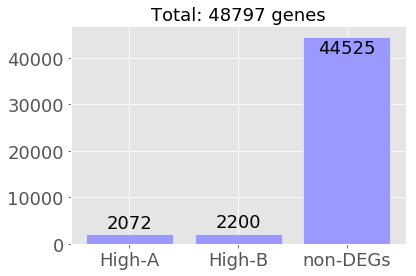

In [143]:
# 比較した遺伝子数
print('遺伝子総数:', len(RES))  

# 発現量に差があった遺伝子数
sub = RES[RES['FDR']<0.05]
print('発現変動遺伝子数:', len(sub))

# サンプルAで多く発現していた遺伝子数
subA = sub[sub['logFC']>0]
subB = sub[sub['logFC']<0]
print('サンプルA高発現:', len(subA))
print('サンプルB高発現:', len(subB))

# 棒グラフ
def bar_plot(df, log_scale=False):
    from matplotlib import pyplot as plt
    plt.style.use('ggplot')
    
    non = len(df) - len(df[df['FDR']<0.05])
    upA = len(df[(df['FDR']<0.05) & (df['logFC']>0)])
    upB = len(df[(df['FDR']<0.05) & (df['logFC']<0)])
    
    G = plt.bar(
        x      = ['High-A', 'High-B', 'non-DEGs'],
        height = [upA, upB, non], 
        align  = "center",
        log    = log_scale,
        facecolor='#9999ff',
        edgecolor='white',
    )
    
    # フォントサイズ
    plt.tick_params(labelsize=18)
    
    # カウント追加
    plt.text(0, upA*1.2, '%d'%upA, ha='center', va='bottom', size=18)
    plt.text(1, upB*1.2, '%d'%upB, ha='center', va='bottom', size=18)
    plt.text(2, non*0.9, '%d'%non, ha='center', va='bottom', size=18)
    # タイトル部分に遺伝子総数
    plt.title('Total: %d genes'%len(df), size=18)

bar_plot(RES)

## ワード検索

In [144]:
# 検索ワード
KEYWORD = 'resistance'

# サンプルA高発現遺伝子のBLAST情報
subA_BST = pd.merge(subA, BST, left_index=True, right_index=True, how='left')
subA_BST[ subA_BST['sprot_Top_BLASTX_hit'].str.contains(KEYWORD) ]

,female_1,female_2,male_1,male_2,sampleA,sampleB,logFC,logCPM,PValue,FDR,Wolbachia_wVulC,A_vulgare_f_element,A_vulgare_mitochondrion,sex_related_genes,sprot_BLASTX,sprot_Top_BLASTX_hit
TRINITY_DN57174_c10_g6,28,27,0,0,female,male,7.682854,1.226905,1.363114e-08,5.929974e-07,.,.,.,.,MDTE_ECOLI; Multidrug resistance protein MdtE,"MDTE_ECOLI^MDTE_ECOLI^Q:575-210,H:253-366^30.3..."


In [145]:
# サンプルB高発現遺伝子のBLAST情報
subB_BST = pd.merge(subB, BST, left_index=True, right_index=True, how='left')
subB_BST[ subB_BST['sprot_Top_BLASTX_hit'].str.contains(KEYWORD) ]

,female_1,female_2,male_1,male_2,sampleA,sampleB,logFC,logCPM,PValue,FDR,Wolbachia_wVulC,A_vulgare_f_element,A_vulgare_mitochondrion,sex_related_genes,sprot_BLASTX,sprot_Top_BLASTX_hit


## GO Term検索

In [146]:
# function for GO search
def search_go(GO_ID):
    import requests, sys
    import urllib.parse
    import ast
    import json

    requestURL = "https://www.ebi.ac.uk/QuickGO/services/ontology/go/search?query=" + urllib.parse.quote(GO_ID) + "&limit=1&page=1"

    r = requests.get(requestURL, headers={ "Accept" : "application/json"})

    if not r.ok:
        r.raise_for_status()
        sys.exit()
        
    responseBody = r.text
    d = json.loads(responseBody)

    for res in d["results"]:
        print(res['id'])
        print(res['name'])
        print(res['aspect'])

"""
# 性染色体
GO:0000803  sex chromosome

# 性決定
GO:0007530  sex determination
GO:0030237  female sex determination
GO:0030238  male   sex determination
GO:0018993  somatic sex determination
GO:0007538  primary sex determination
GO:0007545  processes downstream of sex determination signal

# 性分化
GO:0007548  sex differentiation
GO:0046660  female sex differentiation
GO:0046661  male   sex differentiation
GO:0048071  sex-specific pigmentation
"""

# 検索ワード
GO_ID = 'GO:0018993'
search_go(GO_ID)

GO:0018993
somatic sex determination
biological_process


In [147]:
# サンプルA高発現遺伝子のGO情報
subA_BST_GO = pd.merge(subA_BST, GO, left_index=True, right_index=True, how='left').fillna('.')
subA_BST_GO[subA_BST_GO['GO'].str.contains(GO_ID)]

,female_1,female_2,male_1,male_2,sampleA,sampleB,logFC,logCPM,PValue,FDR,Wolbachia_wVulC,A_vulgare_f_element,A_vulgare_mitochondrion,sex_related_genes,sprot_BLASTX,sprot_Top_BLASTX_hit,GO
TRINITY_DN56701_c2_g1,36,24,5,4,female,male,2.459121,1.52044,0.000323,0.005842,.,.,.,.,TF3A_RAT; Transcription factor IIIA,"TF3A_RAT^TF3A_RAT^Q:849-118,H:116-346^33.068%I...","GO:0000122,GO:0000975,GO:0000976,GO:0000977,GO..."
TRINITY_DN56701_c2_g1,36,24,5,4,female,male,2.459121,1.52044,0.000323,0.005842,.,.,.,.,TF3A_RAT; Transcription factor IIIA,"TF3A_RAT^TF3A_RAT^Q:849-118,H:116-346^33.068%I...","GO:0000122,GO:0000975,GO:0000976,GO:0000977,GO..."
TRINITY_DN56701_c2_g1,36,24,5,4,female,male,2.459121,1.52044,0.000323,0.005842,.,.,.,.,TF3A_RAT; Transcription factor IIIA,"TF3A_RAT^TF3A_RAT^Q:849-118,H:116-346^33.068%I...","GO:0000122,GO:0000975,GO:0000976,GO:0000977,GO..."
TRINITY_DN56701_c2_g1,36,24,5,4,female,male,2.459121,1.52044,0.000323,0.005842,.,.,.,.,TF3A_RAT; Transcription factor IIIA,"TF3A_RAT^TF3A_RAT^Q:849-118,H:116-346^33.068%I...","GO:0000122,GO:0000975,GO:0000976,GO:0000977,GO..."


In [148]:
# サンプルB高発現遺伝子のGO情報
subB_BST_GO = pd.merge(subB_BST, GO, left_index=True, right_index=True, how='left').fillna('.')
subB_BST_GO[subB_BST_GO['GO'].str.contains(GO_ID)]

,female_1,female_2,male_1,male_2,sampleA,sampleB,logFC,logCPM,PValue,FDR,Wolbachia_wVulC,A_vulgare_f_element,A_vulgare_mitochondrion,sex_related_genes,sprot_BLASTX,sprot_Top_BLASTX_hit,GO


## 出現GO Term カウント

In [149]:
# カウント関数
def count_go(df):
    import pandas as pd
    
    # All Go terms put into one list, "all_GO".
    # Some GO terms are duplicated in the "all_GO".
    all_GO = []
    for each_GOs in df["GO"]:
        GO_list = each_GOs.split(",")
        all_GO.extend(GO_list)

    # Counting GO terms using Pandas series
    result = pd.Series(all_GO).value_counts()

    return pd.DataFrame(result, columns=['count'])

# サンプルA高発現遺伝子のGO Termリスト
subA_GO = pd.merge(subA, GO, left_index=True, right_index=True, how='inner')
subB_GO = pd.merge(subB, GO, left_index=True, right_index=True, how='inner')

subA_CNT = count_go(subA_GO)
subA_CNT.columns = ['sampleA']
subB_CNT = count_go(subB_GO)
subB_CNT.columns = ['sampleB']

COUNT = pd.merge(subA_CNT, subB_CNT, left_index=True, right_index=True, how='outer').fillna(0)

# ファイル書き込み
COUNT.to_csv('DEGs_GO_count.txt', sep='\t', header=True, index=True)

# 表示（最初の10行）
COUNT.head(10)

,sampleA,sampleB
GO:0000003,1.0,1.0
GO:0000014,1.0,0.0
GO:0000015,4.0,0.0
GO:0000018,2.0,0.0
GO:0000027,7.0,0.0
GO:0000028,2.0,0.0
GO:0000030,1.0,0.0
GO:0000041,1.0,2.0
GO:0000049,10.0,1.0
GO:0000050,5.0,0.0


## 反復サンプルの遺伝子発現比較

0.47359374525369957 0.22429103554342608
0.6352897331077562 0.40359304499212406
0.7321847108439697 0.5360944507936676
0.7536904208096645 0.5680492504202492


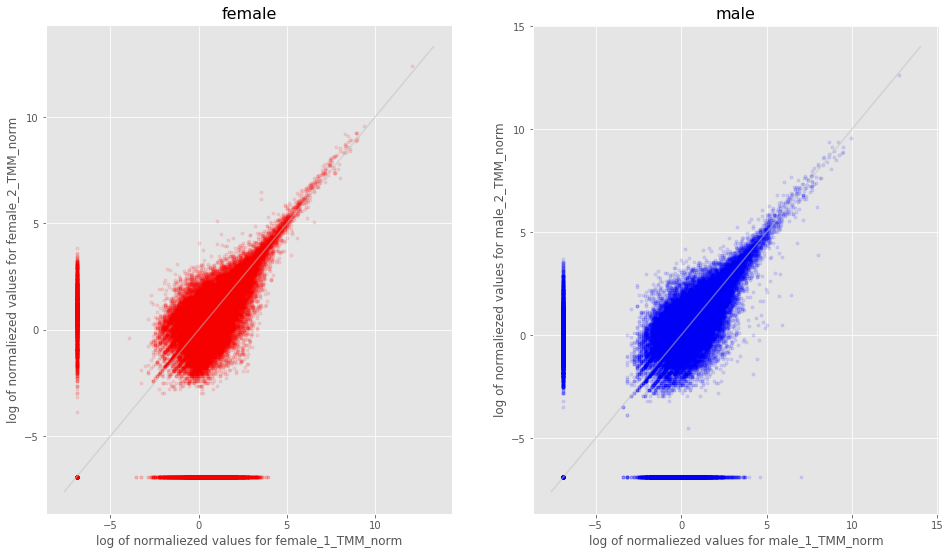

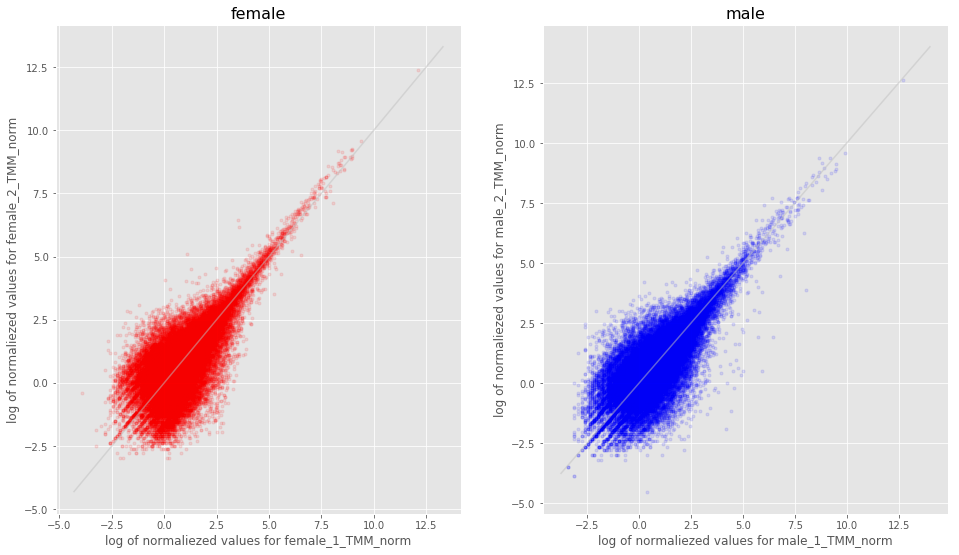

In [153]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

NORM_FILE = 'RSEM.genes.TMM.EXPR.matrix'
NORM = pd.read_csv(NORM_FILE, sep='\t', header=0,  index_col=0)
NORM.columns = NORM.columns + '_TMM_norm'
NORM = pd.merge(RES, NORM, left_index=True, right_index=True, how='left')

def plot_repli_sample(X, Y, T, C):
    # point
    x = np.log(X+0.001)
    y = np.log(Y+0.001)
    plt.plot(x,  y,  '.', color=C,  alpha=0.1)
    
    # line of y=x
    x0=[min(x)*1.1, max(x)*1.1]
    y0=x0
    plt.plot(x0, y0, '-', color='silver', alpha=0.5)
    
    # label
    X_name = X.name
    Y_name = Y.name
    plt.title(T, fontsize=16)
    plt.xlabel("log of normaliezed values for %s" % X_name ,fontsize=12)
    plt.ylabel("log of normaliezed values for %s" % Y_name ,fontsize=12)

def r_squeared(X, Y):
    # R2
    x = np.log(X+0.001)
    y = np.log(Y+0.001)
    r = np.corrcoef(x,y)[0,1]
    print(r, r**2)
    
    
plt.figure(figsize=(16, 9)) 
ax1 = plt.subplot(1,2,1)
ax1 = plot_repli_sample(NORM['female_1_TMM_norm'], NORM['female_2_TMM_norm'], 'female', 'red')
ax2 = plt.subplot(1,2,2)
ax2 = plot_repli_sample(NORM['male_1_TMM_norm'], NORM['male_2_TMM_norm'], 'male', 'blue')

r_squeared(NORM['female_1_TMM_norm'], NORM['female_2_TMM_norm'])
r_squeared(NORM['male_1_TMM_norm'],   NORM['male_2_TMM_norm'])


#### 発現なし遺伝子を除いたR2 ###
F = NORM[(NORM['female_1_TMM_norm']>0) & (NORM['female_2_TMM_norm']>0)]
F = F.loc[:,['female_1_TMM_norm', 'female_2_TMM_norm']]
M = NORM[(NORM['male_1_TMM_norm']>0) & (NORM['male_2_TMM_norm']>0)]
M = M.loc[:,['male_1_TMM_norm', 'male_2_TMM_norm']]

plt.figure(figsize=(16, 9)) 
ax1 = plt.subplot(1,2,1)
ax1 = plot_repli_sample(F['female_1_TMM_norm'], F['female_2_TMM_norm'], 'female', 'red')
ax2 = plt.subplot(1,2,2)
ax2 = plot_repli_sample(M['male_1_TMM_norm'], M['male_2_TMM_norm'], 'male', 'blue')

r_squeared(F['female_1_TMM_norm'], F['female_2_TMM_norm'])
r_squeared(M['male_1_TMM_norm'],   M['male_2_TMM_norm'])